In [3]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import copy
import numpy as np


import datetime as dt
pd.set_option('display.max_columns', 500)

import time
%load_ext autoreload

from collections import defaultdict
from collections import Counter

from functools import lru_cache
import seaborn as sns

from scipy.special import expit
from functools import partial
from multiprocessing import Pool
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import random 

In [6]:
class agent():
    def __init__(self, number, coop, payoff=0):
        self.number = number
        self.coop = coop
        self.payoff = payoff

    def set_coop(self, coop):
        self.coop = coop

        
class circle():
    def __init__(self, n, p, w, b, c = 1, all_coop = True, extra_random = 0):
        self.b = b
        self.c = c

        self.p = p
        self.n = n
        self.w = w
        self.extra_random = extra_random
        self.arr = [agent(i, all_coop) for i in range(n)]
        
        self.global_coop = n if all_coop else 0

        
    def access(self, index):
        return self.arr[index%self.n]
    
    def accessIndex(self, index):
        return index%self.n

    def choose_one_rand(self):
        index = np.random.choice(self.n, 1)[0]
        return self.access(index)
    
    def choose_index_rand(self):
        return random.randrange(0, self.n)
    
    def flip_agent(self, index_flipped):
        current = self.access(index_flipped)
        current.coop = not current.coop
        self.global_coop = sum([i.coop for i in self.arr])
        
 

    def count_coop(self):
        return sum([i.coop for i in self.arr])


    def make_action(self):
        
        self.update_all_payoff()
        index = self.choose_index_rand()
        
        #if random.random() > self.p:
        self.action_local_on(index)
        #else:
        #    self.action_global_on(index)
        
        self.reset_all_payoff()
        

    def action_local_on(self, index): 
        
        ags =  [self.access(index-1), self.access(index), self.access(index+1)] + [self.choose_one_rand() for i in range(self.extra_random)]
        
        defe = [ag.payoff for ag in ags if ag.coop == False]
        coope = [ag.payoff for ag in ags if ag.coop == True]
        
        if len(defe)==0 or len(coope)==0: 
            return
       
        avg_def = np.mean(defe) * self.w 
        avg_coop = np.mean(coope) * self.w
        logitDef = expit(avg_def) / (expit(avg_def) + expit(avg_coop))       
        
        if random.random() < logitDef:
            self.access(index).coop = False
        else:
            self.access(index).coop = True
            
        self.global_coop = sum([i.coop for i in self.arr])
     
         

    def action_global_on(self, index):
        
        choosen_as_rand = self.choose_one_rand()
        me = self.access(index)
        
        if me.coop == choosen_as_rand.coop:
            return
        
        me_score = me.payoff * self.w 
        other_score = choosen_as_rand.payoff * self.w 
        
        logit_other_score = expit(other_score) / (expit(other_score) + expit(me_score))       
        
        if random.random() < logit_other_score:
            me.coop = choosen_as_rand.coop
            self.global_coop = sum([i.coop for i in self.arr])
        

    def update_all_payoff(self):
        for a in self.arr:
            if a.coop:
                self.access(a.number + 1).payoff += self.b
                self.access(a.number - 1).payoff += self.b
                a.payoff -= 2 * self.c
            else:
                pass
           
        
    def reset_all_payoff(self):
        for a in self.arr:
            a.payoff = 0

            
            
def _runModel(i, n, p, w, b, all_coop, extra_random):
    random.seed(int(time.time() + i))
    c = circle(n=n, p=p, w=w, b=b, all_coop=all_coop, extra_random=extra_random)
    c.flip_agent(0)
    
    n_iter = 0
    while True:
        n_iter += 1
        if c.global_coop == 0 or c.global_coop == c.n: 
            break

        c.make_action()

    return all([i.coop != all_coop  for i in c.arr]), n_iter





def runModel(iteration, n, p, w, b, all_coop, extra_random):
    nRun = iteration
    __runModel = partial(_runModel, n=n, p=p, w=w, b=b, all_coop=all_coop, extra_random=extra_random)

    with Pool(12) as p:
          r = list(tqdm(p.imap(__runModel, range(nRun)), total=nRun))    
     
    final_r = [i[0] for i in r]
    iterations = [(i[1],i[0]) for i in r]
    
    fix = sum(final_r)/len(final_r)
    return fix, iterations

# Strong vs Weak

In [ ]:
res_strong = [(i, runModel(200, n=20, p=0, w=0.2, b=7, all_coop=False, extra_random=i)[0]) for i in range(5)]
res_weak   = [(i, runModel(200, n=20, p=0, w=0.02, b=7, all_coop=False, extra_random=i)[0]) for i in range(5)]


  7%|▋         | 14/200 [00:03<05:23,  1.74s/it]

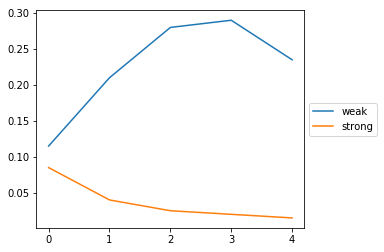

In [13]:
plt.plot([i for i,j in res_weak], [j for i,j in res_weak], label = "weak")
plt.plot([i for i,j in res_strong], [j for i,j in res_strong], label = "strong")

# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [14]:
res_strong = [(i, runModel(2000, n=20, p=0, w=0.2, b=7, all_coop=False, extra_random=i)[0]) for i in range(5)]
res_weak   = [(i, runModel(2000, n=20, p=0, w=0.02, b=7, all_coop=False, extra_random=i)[0]) for i in range(5)]

100%|██████████| 2000/2000 [27:42<00:00,  1.20it/s]


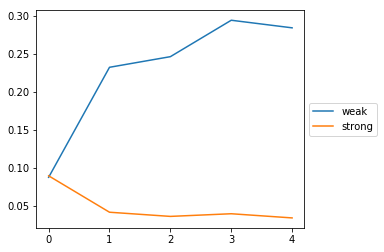

In [18]:
plt.plot([i for i,j in res_weak], [j for i,j in res_weak], label = "weak")
plt.plot([i for i,j in res_strong], [j for i,j in res_strong], label = "strong")


# Shrink current axis by 20%
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [20]:
with open('weak(N20i2000b7w0.2).txt', 'w') as outfile:  
    json.dump(res_strong, outfile)
    
with open('strong(N20i2000b7w0.2).txt', 'w') as outfile:  
    json.dump(res_weak, outfile)

In [ ]:
# Try 

In [6]:
fix, iteration = runModel(100, n=30, p=0, w=0.01, b=5, all_coop=False, extra_random=0)
print(fix)
max([i for i,j in iteration])

100%|██████████| 100/100 [00:00<00:00, 244.84it/s]


0.09


11582

In [7]:
fix, iteration = runModel(100, n=30, p=0, w=0.01, b=5, all_coop=False, extra_random=1)
print(fix)
max([i for i,j in iteration])

100%|██████████| 100/100 [00:38<00:00,  2.59it/s]

0.21


177694

In [8]:
fix, iteration = runModel(100, n=30, p=0, w=0.01, b=5, all_coop=False, extra_random=2)
print(fix)
sum([i for i,j in iteration])

100%|██████████| 100/100 [07:58<00:00,  4.79s/it]

0.22


26889750

In [8]:
fix, iteration =runModel(1000, n=30, p=0, w=1, b=5, all_coop=False)

100%|██████████| 1000/1000 [00:00<00:00, 1578.02it/s]


0.013

# Find w

100%|██████████| 1000/1000 [00:00<00:00, 7246.38it/s]


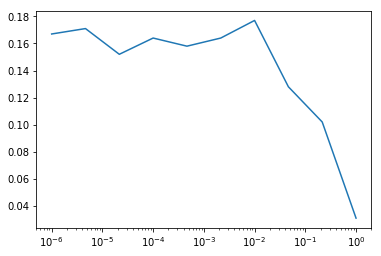

In [150]:
ws = np.logspace(-6, 0, 10)
res_w = list()
for w in ws:
    res_w.append(runModel(1000, n = 10, p=0, w=w, b=5, all_coop=False))
    
plt.plot(ws, res_w)
plt.xscale("log")

100%|██████████| 1000/1000 [00:00<00:00, 2223.86it/s]


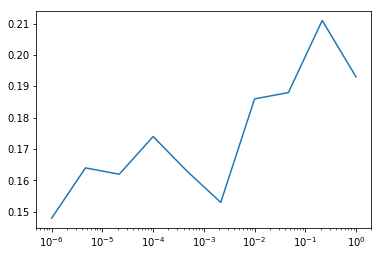

In [152]:
ws = np.logspace(-6, 0, 10)
res_w = list()
for w in ws:
    res_w.append(runModel(1000, n = 10, p=0, w=w, b=5, all_coop=True))
    
plt.plot(ws, res_w)
plt.xscale("log")

# How COOP go with p

In [ ]:
ps = np.arange(0, 1, 0.1)
coops = [runModel(5000, n = 30, p=p, w=0.01, b=5, all_coop=False) for p in ps]

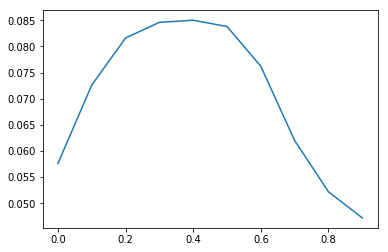

In [23]:
plt.plot(ps, coops)

In [7]:
ps = np.arange(0, 1, 0.1)
coops = [runModel(5000, n = 30, p=p, w=0.01, b=5, all_coop=True) for p in ps]

100%|██████████| 5000/5000 [00:12<00:00, 400.14it/s]


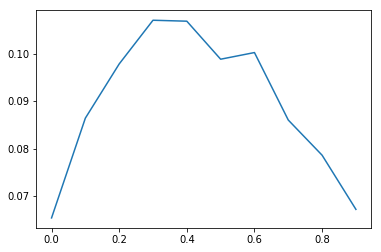

In [8]:
plt.plot(ps, coops)

# Intersection

In [65]:
def coopBigger(b, p):
    fixDef =  runModel(500, n=30, p=p, w=0.1, b=b, all_coop=True)[0]
    fixCoop = runModel(500, n=30, p=p, w=0.1, b=b, all_coop=False)[0]
    
    return fixCoop>fixDef

In [66]:
def runBinary(p, startingB):
    in_left = False
    
    b = startingB
    while True:
        if coopBigger(b, p):
            break
        in_left = True
        b = b*2
       
        if b>20: 
            return np.nan
            print("b too big")
    
    
    if not in_left: 
        print("b must be in left part")
        return np.nan
    
    a = b/2
    
    while (b-a > 0.1):
        print((a,b))
        m = (b+a)/2
        if coopBigger(m, p):
            b = m
        else:
            a = m
    
    print((f"final res {m} with {p}"))       
    return m

In [68]:
ps = list(np.arange(0, 0.3, 0.02))
ps = ps + list(np.arange(0.3, 0.5, 0.05))
len(ps)

19

In [69]:
ris_bin = list()
for i in ps:
    ris_bin.append((i, runBinary(i, 3)))
    pd.DataFrame(ris_bin).to_csv("./runALot")

100%|██████████| 500/500 [00:01<00:00, 257.73it/s]

(3.0, 6)



100%|██████████| 500/500 [00:01<00:00, 285.62it/s]

(4.5, 6)



100%|██████████| 500/500 [00:02<00:00, 243.79it/s]


(4.5, 5.25)


100%|██████████| 500/500 [00:02<00:00, 246.92it/s]


(4.5, 4.875)


100%|██████████| 500/500 [00:01<00:00, 265.93it/s]

(4.5, 4.6875)



100%|██████████| 500/500 [00:01<00:00, 283.94it/s]

final res 4.59375 with 0.0



100%|██████████| 500/500 [00:01<00:00, 293.03it/s]

(3.0, 6)



100%|██████████| 500/500 [00:01<00:00, 347.79it/s]


(4.5, 6)


100%|██████████| 500/500 [00:01<00:00, 369.08it/s]

(5.25, 6)



100%|██████████| 500/500 [00:01<00:00, 316.55it/s]

(5.25, 5.625)



100%|██████████| 500/500 [00:01<00:00, 384.00it/s]


(5.4375, 5.625)


100%|██████████| 500/500 [00:01<00:00, 321.80it/s]

final res 5.53125 with 0.02



100%|██████████| 500/500 [00:01<00:00, 381.40it/s]

(6.0, 12)



100%|██████████| 500/500 [00:01<00:00, 333.17it/s]


(6.0, 9.0)


100%|██████████| 500/500 [00:01<00:00, 362.19it/s]

(6.0, 7.5)



100%|██████████| 500/500 [00:01<00:00, 340.85it/s]

(6.0, 6.75)



100%|██████████| 500/500 [00:01<00:00, 311.52it/s]


(6.0, 6.375)


100%|██████████| 500/500 [00:01<00:00, 291.49it/s]

(6.0, 6.1875)



100%|██████████| 500/500 [00:01<00:00, 295.60it/s]

final res 6.09375 with 0.04



100%|██████████| 500/500 [00:01<00:00, 360.61it/s]

(6.0, 12)



100%|██████████| 500/500 [00:01<00:00, 327.55it/s]


(6.0, 9.0)


100%|██████████| 500/500 [00:01<00:00, 363.58it/s]

(6.0, 7.5)



100%|██████████| 500/500 [00:01<00:00, 332.96it/s]


(6.75, 7.5)


100%|██████████| 500/500 [00:01<00:00, 343.17it/s]

(7.125, 7.5)



100%|██████████| 500/500 [00:01<00:00, 327.53it/s]

(7.125, 7.3125)



100%|██████████| 500/500 [00:01<00:00, 360.94it/s]

final res 7.21875 with 0.06



100%|██████████| 500/500 [00:01<00:00, 317.47it/s]

(6.0, 12)



100%|██████████| 500/500 [00:01<00:00, 321.60it/s]


(6.0, 9.0)


100%|██████████| 500/500 [00:01<00:00, 315.72it/s]

(6.0, 7.5)



100%|██████████| 500/500 [00:01<00:00, 322.18it/s]

(6.75, 7.5)



100%|██████████| 500/500 [00:01<00:00, 280.21it/s]


(7.125, 7.5)


100%|██████████| 500/500 [00:01<00:00, 365.11it/s]

(7.3125, 7.5)



100%|██████████| 500/500 [00:01<00:00, 285.85it/s]

final res 7.40625 with 0.08



100%|██████████| 500/500 [00:01<00:00, 106.66it/s]

(6.0, 12)



100%|██████████| 500/500 [00:01<00:00, 310.72it/s]

(6.0, 9.0)



100%|██████████| 500/500 [00:01<00:00, 393.61it/s]

(7.5, 9.0)



100%|██████████| 500/500 [00:01<00:00, 416.26it/s]

(8.25, 9.0)



100%|██████████| 500/500 [00:01<00:00, 352.02it/s]

(8.625, 9.0)



100%|██████████| 500/500 [00:01<00:00, 366.63it/s]

(8.625, 8.8125)



100%|██████████| 500/500 [00:01<00:00, 345.59it/s]

final res 8.71875 with 0.1



100%|██████████| 500/500 [00:01<00:00, 289.14it/s]


(6.0, 12)


100%|██████████| 500/500 [00:01<00:00, 365.68it/s]

(9.0, 12)



100%|██████████| 500/500 [00:01<00:00, 317.73it/s]

(10.5, 12)



100%|██████████| 500/500 [00:01<00:00, 327.20it/s]

(10.5, 11.25)



100%|██████████| 500/500 [00:01<00:00, 323.46it/s]


(10.5, 10.875)


100%|██████████| 500/500 [00:01<00:00, 376.10it/s]

(10.5, 10.6875)



100%|██████████| 500/500 [00:01<00:00, 339.67it/s]

final res 10.59375 with 0.12



100%|██████████| 500/500 [00:01<00:00, 341.27it/s]

(6.0, 12)



100%|██████████| 500/500 [00:01<00:00, 283.13it/s]

(6.0, 9.0)



100%|██████████| 500/500 [00:01<00:00, 359.40it/s]


(7.5, 9.0)


100%|██████████| 500/500 [00:01<00:00, 365.16it/s]


(8.25, 9.0)


100%|██████████| 500/500 [00:01<00:00, 307.38it/s]


(8.625, 9.0)


100%|██████████| 500/500 [00:01<00:00, 337.26it/s]

(8.8125, 9.0)



100%|██████████| 500/500 [00:01<00:00, 354.64it/s]


final res 8.90625 with 0.14


100%|██████████| 500/500 [00:01<00:00, 342.06it/s]

(6.0, 12)



100%|██████████| 500/500 [00:01<00:00, 288.75it/s]

(9.0, 12)



100%|██████████| 500/500 [00:01<00:00, 382.66it/s]


(10.5, 12)


100%|██████████| 500/500 [00:01<00:00, 280.20it/s]


(11.25, 12)


100%|██████████| 500/500 [00:02<00:00, 242.30it/s]

(11.25, 11.625)



100%|██████████| 500/500 [00:01<00:00, 334.73it/s]

(11.4375, 11.625)



100%|██████████| 500/500 [00:01<00:00, 335.93it/s]

final res 11.53125 with 0.18



100%|██████████| 500/500 [00:01<00:00, 259.66it/s]


(6.0, 12)


100%|██████████| 500/500 [00:01<00:00, 255.22it/s]

(9.0, 12)



100%|██████████| 500/500 [00:01<00:00, 355.58it/s]


(10.5, 12)


100%|██████████| 500/500 [00:02<00:00, 247.62it/s]

(11.25, 12)



100%|██████████| 500/500 [00:01<00:00, 295.26it/s]

(11.625, 12)



100%|██████████| 500/500 [00:01<00:00, 268.38it/s]


(11.8125, 12)


100%|██████████| 500/500 [00:01<00:00, 308.17it/s]

final res 11.90625 with 0.24



100%|██████████| 500/500 [00:01<00:00, 338.33it/s]


In [56]:
pd.DataFrame(ris_bin)#.to_csv("./run2")

,0,1
0,0.00,9.28125
1,0.02,8.15625
2,0.04,NaN
3,0.06,5.15625
4,0.08,NaN
5,0.10,8.15625
6,0.12,4.40625
7,0.14,NaN
8,0.16,5.15625
9,0.18,NaN


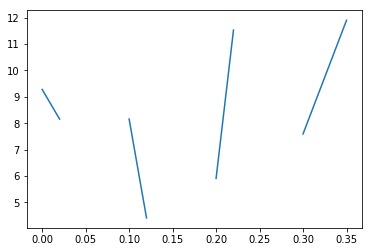

In [59]:
plt.plot([i[0] for i in ris_bin], [i[1] for i in ris_bin])

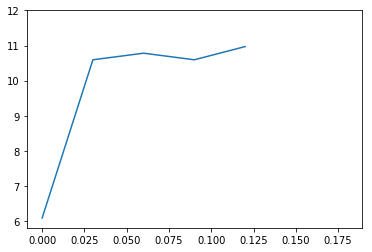

In [29]:
plt.plot(ps, ris_bin)

In [10]:
fix_def = list()
bs = np.arange(4, 10, 1)
for b in bs:
    fix_def.append(runModel(5000, n=30, p=0.05, w=0.1, b=b, all_coop=True, extra_random=0))
    
fix_coop = list()
for b in bs:
    fix_coop.append(runModel(5000, n=30, p=0.05, w=0.1, b=b, all_coop=False, extra_random=0))

100%|██████████| 5000/5000 [01:03<00:00, 79.02it/s]


ValueError: x and y must have same first dimension, but have shapes (6,) and (12, 5, 2)

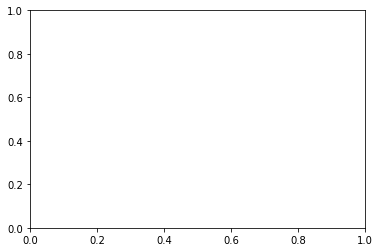

In [9]:
plt.plot(bs, fix_def)
plt.plot(bs, fix_coop)

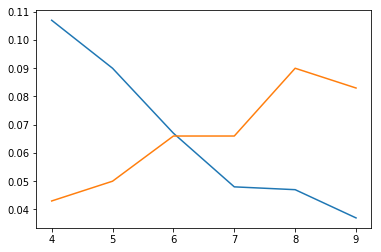

In [62]:
plt.plot(bs, fix_def)
plt.plot(bs, fix_coop)

In [43]:
fix_def

[19.116, 17.6376, 16.8792, 16.467, 16.3326, 16.2636]

In [36]:
fix_coop = list()
bs = np.arange(0, 6, 0.5)
bs = np.arange(0, 50, 5)

for b in bs:
    fix_coop.append(runModel(10000, n=50, p=0, w=0.5, b=b, all_coop=False))

100%|██████████| 10000/10000 [00:44<00:00, 226.48it/s]


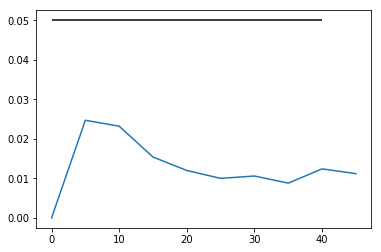

In [39]:
plt.plot(bs, fix_coop)
plt.hlines(0.05, 0, 40)

In [18]:
fix_def = list()
bs = np.arange(0, 20, 2)
for b in bs:
    fix_def.append(runModel(5000, n = 10, p=0, w=0.01, b=b, all_coop=True))

100%|██████████| 5000/5000 [00:02<00:00, 1983.50it/s]


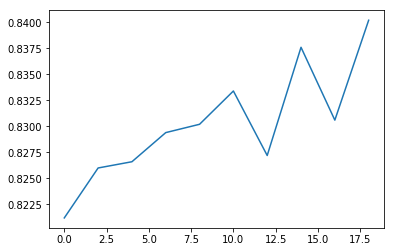

In [19]:
plt.plot(bs, fix_def)

Text(0, 0.5, 'num of cooperators')

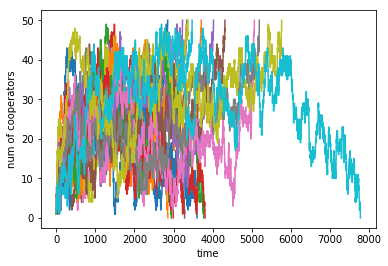

In [22]:
r_long = sorted(r, key = lambda a: len(a))[-20:]

for path in r_long:
    plt.plot(path)
    
plt.xlabel('time')
plt.ylabel('num of cooperators')
#plt.title('fuck off we dont know you', fontsize=70)
#plt.savefig('goodone.eps', format='eps', dpi=1000)

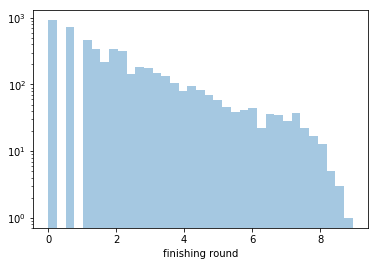

In [21]:
sns.distplot(np.log([len(i) for i in r]), kde=False)
plt.yscale("log")
plt.xlabel('finishing round')
plt.ylabel('')
plt.savefig('distgoodone.png')

In [18]:
# ratio

In [37]:
final = Counter([i[-1] for i in r])
final

Counter({0: 30000})

In [29]:
final[list(final.keys())[0]]/sum(list(final.values()))

0.9975966666666667

In [30]:
final[list(final.keys())[1]]/sum(list(final.values()))

0.0024033333333333333

# Check exp

In [39]:
exponent = 10
1/(1+np.exp(-exponent))

0.9999546021312976

In [40]:
exponent = -10
1/(1+np.exp(-exponent))

4.5397868702434395e-05

In [41]:
from scipy.special import expit

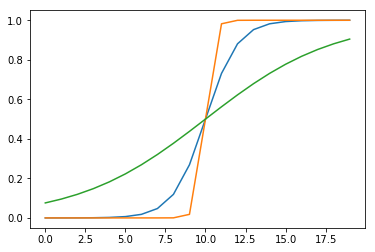

In [55]:
plt.plot([expit(i) for i in range(-10, 10)])
plt.plot([expit(4*i) for i in range(-10, 10)])
plt.plot([expit(i/4) for i in range(-10, 10)])

In [12]:
ws = [0.01]
ps = np.arange(0, 1.1, 0.1)

means_total = list()
sims_total = list()

for w in ws:
    means=list()
    stds=list()
    sims = list()
    
    coops = [runModel(100, n=30, p=p, w=w, b=5, all_coop=False, extra_random=0) for p in ps]
        
    for lista in coops:
        tmp = list()
        indice = 0

        for item in lista[2]:
            if item: tmp.append(lista[1][indice])
            indice += 1

        sims.append(len(tmp))

    sims_total.append(sims)
    plt.scatter(ps, sims, label='w={}'.format(w))
    
    
plt.ylabel('fixation of cooperation')
plt.xlabel('p')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig('fixation_prob.eps', format='eps', dpi=5000)

100%|██████████| 100/100 [00:02<00:00, 35.28it/s]


IndexError: tuple index out of range

In [ ]:
i = 0

#sims_total = data = pd.read_csv("data_sims_prob.csv") 
#tmp_sims = sims_total + sims_total_tmp


for item in sims_total:
    item = np.true_divide(item, 5000)
    plt.scatter(ps, item)
    plt.plot(ps, item, label='w={}'.format(ws[i]))
    i += 1
    
plt.hlines(1/30, 0, 1, label='well-mixed')
plt.xlabel('p')
plt.ylabel('fixation probability')
#plt.title('fixation prob. for different selection strengths')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

plt.savefig('fixation_prob.eps', format='eps', dpi=5000)
